<a href="https://colab.research.google.com/github/sytnax-erorr/kaggle-competitions/blob/master/mnist_handwritten_digit_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os

In [3]:
os.chdir('/content/drive/My Drive/Colab Notebooks/comofi')

In [4]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

--2020-09-25 06:46:58--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.28.7.204, 172.67.171.76, 104.28.6.204, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.28.7.204|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  11.2MB/s    in 0.8s    

2020-09-25 06:46:59 (11.2 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2020-09-25 06:46:59--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.28.7.204, 104.28.6.204, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===================>]  28.20K  --.-K

In [ ]:
!gunzip t*-ubyte.gz

gzip: t10k-images-idx3-ubyte already exists; do you wish to overwrite (y or n)? y
gzip: t10k-labels-idx1-ubyte already exists; do you wish to overwrite (y or n)? y
gzip: train-images-idx3-ubyte already exists; do you wish to overwrite (y or n)? y
gzip: train-labels-idx1-ubyte already exists; do you wish to overwrite (y or n)? y


In [6]:
!pip install python-mnist

In [5]:
from mnist import MNIST

mnist = MNIST('./')
x_train, y_train = mnist.load_training() 
x_test, y_test = mnist.load_testing()

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
x_train = np.asarray(x_train, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32)
x_test = np.asarray(x_test, dtype=np.float32)
y_test = np.asarray(y_test, dtype=np.float32)

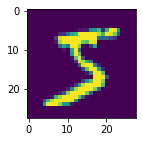

In [8]:
plt.figure(figsize=(2,2))
plt.imshow(x_train[0].reshape(28,28))

### Besic EDA
**Since this data is already preprocessed and formatted**

<BarContainer object of 10 artists>

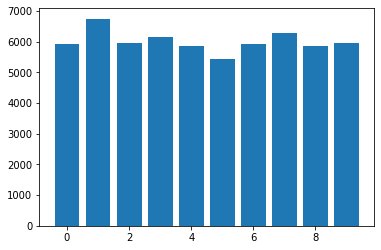

In [9]:
number, number_count = np.unique(y_train,return_counts=True)
plt.bar(number,number_count)

Above Graph shows that the data is balanced (means, dataset nearly have equal number of samples so we don't have to increase or decrease any perticular sample to make data balance)

In [10]:
#checking for null values
sum(np.isnan(y_train)) , sum(np.isnan(y_test))

(0, 0)

In [11]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, models
from torchsummary import summary


In [14]:
#Dataset preparation

class DigitDataset(Dataset):

  def __init__( self, images, labels, transform = None ):
    self.labels = labels
    if self.labels is None:
      self.labels = np.zeros(len(images))

    self.images = images
    self.images = self.images.reshape(-1,1,28,28)
    self.images = torch.from_numpy(self.images)

    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    label = self.labels[index]
    image = self.images[index]

    if self.transform:
      image = self.transform(image)

    return image, label


Modeling and Creating Data for Training and Validation


In [15]:
BATCH_SIZE = 128

#Dividing training data into 8:2 ratio and preserving 20% data for validation purposes.
VALID_SIZE = 0.2 

#Data Augmentations pipeline
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

transform_valid = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [16]:
#checking if GPU is aviable or not
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:

train_data = DigitDataset(x_train, y_train, transform=transform_train)
valid_data = DigitDataset(x_train, y_train, transform=transform_valid)

Generating random training and validation indexes

In [18]:

num_train = len(x_train)
indices = list(range(num_train)) 
np.random.shuffle(indices) 
split = int(np.floor(VALID_SIZE * num_train))
train_idx, valid_idx = indices[split:], indices[:split] 

train_sampler = SubsetRandomSampler(train_idx) 
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, sampler=valid_sampler)

print("Size of Train Set: ", len(train_idx))
print("Size of Valid Set: ", len(valid_idx))

Size of Train Set:  48000
Size of Valid Set:  12000


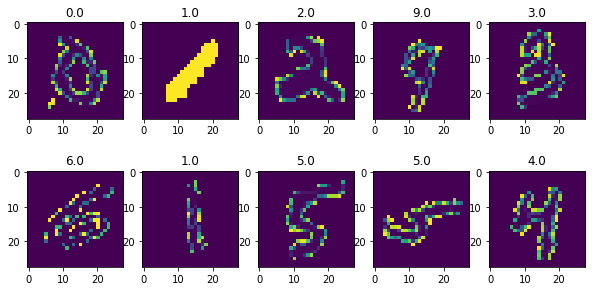

In [19]:

fig, axis = plt.subplots(2, 5, figsize=(10, 5))
images, labels = next(iter(train_loader))

for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(image[0])
        ax.set(title = f"{label}")

Generating Model

In [20]:

class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.fc = nn.Linear(64*7*7, 10)
        self.bn_fc = nn.BatchNorm1d(10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.bn_fc(out)
        
        return out
    
model = CNN_model().to(device)

summary(model, ( 1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           2,320
       BatchNorm2d-5           [-1, 16, 28, 28]              32
              ReLU-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 32, 14, 14]           4,640
       BatchNorm2d-9           [-1, 32, 14, 14]              64
             ReLU-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,248
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32, 14, 14]               0
        MaxPool2d-14             [-1, 3

In [21]:
criterion = nn.CrossEntropyLoss() #Loss function

learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


In [22]:
EPOCHS = 20 #number of epoch to train model

valid_loss_min = np.Inf #min loss for saving best model
train_losses, valid_losses = [], []
accuracy_list=[]

N_valid = len(valid_idx)

Training Model

In [ ]:
for epoch in range(EPOCHS):
    train_loss = 0
    
    # set to train whenever needs to train
    model.train()

    for x, y in train_loader:
      
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y.type(torch.long))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    valid_loss = 0
    correct = 0
    accuracy = 0
    
    with torch.no_grad():
    # set to eval to evaluate the performance of current model
        model.eval()

        for x_val, y_val in valid_loader:
            
            x_val, y_val = x_val.to(device), y_val.to(device)

            z = model(x_val)
            valid_loss += criterion(z, y_val.type(torch.long)).item()
            # get the class of predicted value
            _, yhat = torch.max(z.data, 1)
            # count the results that have been predicted correctly
            correct += (yhat == y_val).sum().item() 
        
    accuracy = correct / N_valid
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)
    accuracy_list.append(accuracy)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f"Epoch: {epoch}/{EPOCHS} ",
          f"Training Loss: {train_loss:.4f} ",
          f"Validation Loss: {valid_loss:.4f} ",
          f"Test Accuracy: {accuracy:.4f}")
    
    #check is this model perform better in valid loss
    network_learned = valid_loss < valid_loss_min
    
    if network_learned:
        valid_loss_min = valid_loss
        
        checkpoint = {'model': CNN_model(),
                      'state_dict': model.state_dict(),
                      'optimizer' : optimizer.state_dict()}

        torch.save(checkpoint, 'model_mnist.pth')
        print("Saved this model!")
        

Epoch: 0/20  Training Loss: 0.1520  Validation Loss: 0.2788  Test Accuracy: 0.9615
Saved this model!
Epoch: 1/20  Training Loss: 0.1151  Validation Loss: 0.0750  Test Accuracy: 0.9888
Saved this model!
Epoch: 2/20  Training Loss: 0.0920  Validation Loss: 0.0554  Test Accuracy: 0.9915
Saved this model!
Epoch: 3/20  Training Loss: 0.0786  Validation Loss: 0.0935  Test Accuracy: 0.9872
Epoch: 4/20  Training Loss: 0.0675  Validation Loss: 0.0388  Test Accuracy: 0.9922
Saved this model!
Epoch: 5/20  Training Loss: 0.0573  Validation Loss: 0.0391  Test Accuracy: 0.9908
Epoch: 6/20  Training Loss: 0.0520  Validation Loss: 0.0328  Test Accuracy: 0.9936
Saved this model!
Epoch: 7/20  Training Loss: 0.0482  Validation Loss: 0.0325  Test Accuracy: 0.9934
Saved this model!
Epoch: 8/20  Training Loss: 0.0433  Validation Loss: 0.0305  Test Accuracy: 0.9938
Saved this model!
Epoch: 9/20  Training Loss: 0.0391  Validation Loss: 0.0305  Test Accuracy: 0.9933
Epoch: 10/20  Training Loss: 0.0348  Validat

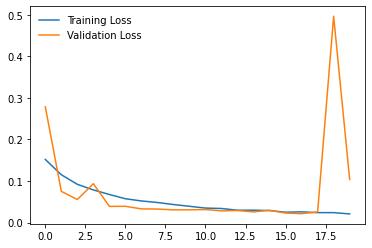

In [ ]:

plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend(frameon=False)
plt.show()

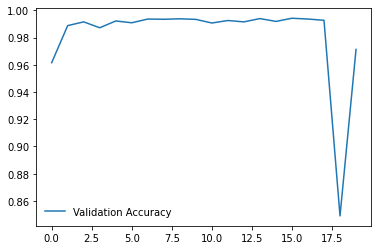

In [ ]:
plt.plot(accuracy_list, label='Validation Accuracy')
plt.legend(frameon=False)
plt.show()

Loading model weights which has minimum loss value

In [ ]:
checkpoint = torch.load('model_mnist.pth')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
print(model)

CNN_model(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, k

In [ ]:

#test dataloader
test_data = DigitDataset(x_test, torch.zeros(len(y_test)), transform=transform_valid)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


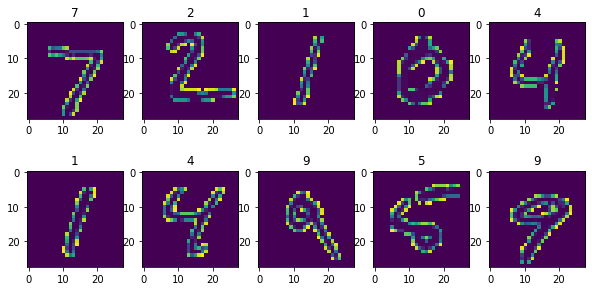

In [ ]:
# visualizing few test image 

fig, axis = plt.subplots(2, 5, figsize=(10, 5))
images,_ =  next(iter(test_loader))

for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        model.eval()
        img = images[i]
        img_test = img.unsqueeze(0)

        img_test = img_test.to(device)
            
        z = model(img_test)
        _, yhat = torch.max(z.data, 1)
        ax.imshow(img.squeeze(0))
        ax.set(title = f"{yhat.item()}")


Predicting values


In [ ]:
pred_y = []
img_id = 1

with torch.no_grad():
    model.eval()
    for x,_ in test_loader:
     
        x = x.to(device)
        z = model(x)
        _, yhat = torch.max(z.data, 1)
        
        for pred in yhat:
            pred_y.append(pred.item())

pred_y = np.array(pred_y)            
print(f"Submission size: {len(pred_y)}")
print(f"Test data size: {len(x_test)}")

Submission size: 10000
Test data size: 10000


In [ ]:
from sklearn.metrics import accuracy_score

Calculating Accuracy


In [90]:
acc = accuracy_score( pred_y, y_test ) # y_test - is origianl value & pred_y - predicted value
acc

0.9962

**99.62% accuracy only in 20 epoch, and even only one   Image Augmentation technique I have used (Image Rotation only)... we can improve the accuracy with the same model architecture if we add a few more augmentation like grid mark, shearing, center croping, scaling etc.**

##Solution 2: Using Keras and TF as Backend

using Keras library we can implement the classifier in very few lines of code.. as it provides lots of built-in functions...

In [12]:
#importing libraries

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras.utils.np_utils import to_categorical

In [13]:
#loading datasets

mnist = MNIST('./')
x_train, y_train = mnist.load_training() 
x_test, y_test = mnist.load_testing()

In [14]:
#Converting to numpy array
x_train = np.asarray(x_train, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32)
x_test = np.asarray(x_test, dtype=np.float32)
y_test = np.asarray(y_test, dtype=np.float32)

In [15]:
# Reshaping image 
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [16]:
#implementing one hot encoding..
y_train = to_categorical(y_train, num_classes = 10)

Data preparation

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# Normalizing the data
x_train = x_train / 255.0
x_test = x_test / 255.0

SEED = 103
BATCH_SIZE = 128
EPOCHS = 10

# Split the train and the validation set for the fitting
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=SEED)

In [20]:
# Creating a Sequential NN model 

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

In [21]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, decay=0.0)

In [22]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [23]:
#this will decrease the learning rate by some factor.. if there is no improvement in val_accuracy..
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',        
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

\# Data augmentation

In [24]:
#generating image data
datagen = ImageDataGenerator(
          rotation_range=10,  
          zoom_range = 0.1, 
          width_shift_range=0.1,  
          height_shift_range=0.1
        )


In [64]:
# Fit the model
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=BATCH_SIZE),
                              epochs = EPOCHS, validation_data = (x_val,y_val),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // BATCH_SIZE
                              , callbacks=[learning_rate_reduction])

Epoch 1/10
421/421 [==============================] - 15s 35ms/step - loss: 0.1072 - accuracy: 0.9688 - val_loss: 0.0369 - val_accuracy: 0.9882
Epoch 2/10
421/421 [==============================] - 15s 35ms/step - loss: 0.1022 - accuracy: 0.9697 - val_loss: 0.0379 - val_accuracy: 0.9877
Epoch 3/10
421/421 [==============================] - 15s 35ms/step - loss: 0.1010 - accuracy: 0.9702 - val_loss: 0.0365 - val_accuracy: 0.9893
Epoch 4/10
421/421 [==============================] - 14s 34ms/step - loss: 0.0990 - accuracy: 0.9713 - val_loss: 0.0358 - val_accuracy: 0.9897
Epoch 5/10
421/421 [==============================] - 14s 34ms/step - loss: 0.0939 - accuracy: 0.9729 - val_loss: 0.0323 - val_accuracy: 0.9885
Epoch 6/10
421/421 [==============================] - 15s 35ms/step - loss: 0.0958 - accuracy: 0.9721 - val_loss: 0.0335 - val_accuracy: 0.9892
Epoch 7/10
420/421 [============================>.] - ETA: 0s - loss: 0.0935 - accuracy: 0.9737
Epoch 00007: ReduceLROnPlateau reducing 

\# Training and validation curves

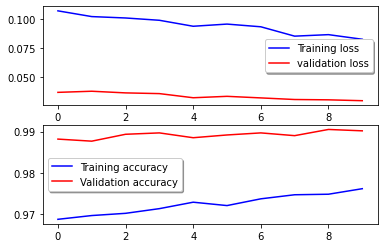

In [65]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [66]:

predictions = model(x_test)

predictions = np.argmax(predictions, axis=1)


In [67]:
from sklearn.metrics import accuracy_score

In [97]:
acc = accuracy_score(predictions,y_test)
acc

0.9952

**99.52% of accuracy in just a few lines of code, further we can use the Hyperparameter optimization technique to get more accuracy.**

##Now, using above trained model lets recognize hand written digit from an image

In [31]:
import cv2

you can try your own image, just give the absolute path for an image

In [87]:
IMAGE_URL = ''
IMAGE_NAME = 'IMG-2765.jpg'

In [79]:
if IMAGE_URL and IMAGE_NAME:
  !wget $IMAGE_URL

In [80]:
img = cv2.imread(IMAGE_NAME)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


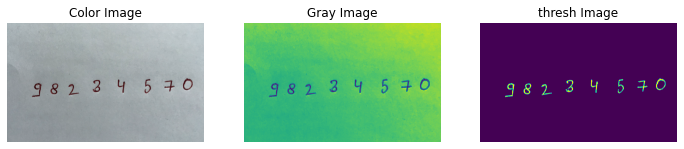

In [81]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.title("Color Image")
plt.axis('off')
plt.imshow(img)

plt.subplot(1,3,2)
plt.title("Gray Image")
plt.axis('off')
plt.imshow(gray)

_, thresh = cv2.threshold(gray.copy(),80,255,cv2.THRESH_BINARY_INV)

plt.subplot(1,3,3)
plt.title("thresh Image")
plt.axis('off')
plt.imshow(thresh)

In [88]:
#now find digits in image 

contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


In [83]:
preprocessed_digits = []

for c in contours:
  x,y,w,h = cv2.boundingRect(c)
  if w<50: #just hyper paramerter to tune, depend on input image size
    continue
  cv2.rectangle(img,(x,y),(x+w,y+h),thickness=8,color=(255,0,0))
  digit = thresh[y:y+h, x:x+w]
  resized_digit = cv2.resize(digit, (18,18))
  padded_digit = np.pad(resized_digit, ((5,5),(5,5)), "constant", constant_values=0)
  preprocessed_digits.append(padded_digit)

(-0.5, 3211.5, 1943.5, -0.5)

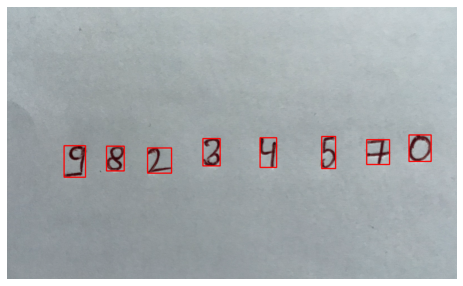

In [84]:
plt.figure(figsize=(10,5))
plt.imshow(img)
plt.axis('off')

In [85]:
#arranging in format so, we can directly feed it to model

preprocessed_digits = list(map(lambda x:x[...,np.newaxis],preprocessed_digits))
preprocessed_digits = np.asarray(preprocessed_digits)


In [86]:
_p = model(preprocessed_digits)
_p = np.argmax(_p, axis=1)
_p

array([2, 8, 9, 7, 3, 4, 5, 0])

**These digits are not in exact order as in Image... but we have recognised all the digits present in image.. for arranging in order we have to first arrange the images by their x-cordinate..**